<a href="https://colab.research.google.com/github/moushumipriya/Customer-Churn-Prediction/blob/main/Customer_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from imblearn.over_sampling import SMOTE


In [5]:
df = pd.read_csv("data.csv")
df.head()
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [6]:
# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Remove missing TotalCharges
df = df.dropna(subset=['TotalCharges'])

# Encode target variable
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})


In [7]:
cat_cols = df.select_dtypes(include='object').columns.drop('customerID')

le = LabelEncoder()
for col in cat_cols:
    if df[col].nunique() == 2:
        df[col] = le.fit_transform(df[col])
    else:
        df = pd.get_dummies(df, columns=[col], drop_first=True)


In [8]:
X = df.drop(['customerID','Churn'], axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [10]:
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

In [11]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))


Random Forest Accuracy: 0.7867803837953091


In [12]:
param_grid = {'n_estimators':[100,200], 'max_depth':[None,10,20], 'min_samples_split':[2,5]}
grid = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)
print("Best Parameters:", grid.best_params_)
print("Best Accuracy:", grid.best_score_)


Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Best Accuracy: 0.8062222222222223


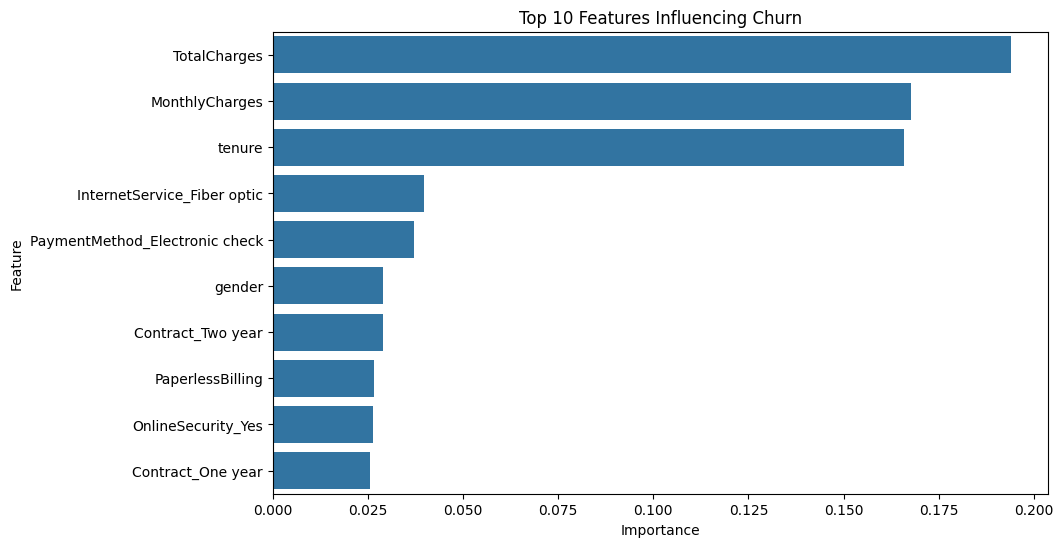

In [13]:
importances = rf_model.feature_importances_
feature_names = X.columns
feat_df = pd.DataFrame({'Feature':feature_names, 'Importance':importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_df.head(10))
plt.title("Top 10 Features Influencing Churn")
plt.show()


In [14]:
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
print("CV Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())


CV Accuracy Scores: [0.79744136 0.79317697 0.77098151 0.79302987 0.79587482]
Mean CV Accuracy: 0.7901009077756916


In [15]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)


In [16]:
voting_clf = VotingClassifier(estimators=[
    ('lr', LogisticRegression()),
    ('rf', RandomForestClassifier()),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
], voting='soft')

voting_clf.fit(X_train, y_train)
print("Voting Classifier Accuracy:", voting_clf.score(X_test, y_test))


Voting Classifier Accuracy: 0.7896233120113717


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:58:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
